In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 1 — Introduction to Machine Learning
# Lesson 6: Key Mathematical Foundations (Linear Algebra, Probability, Optimization)

This lesson is intentionally “math-forward,” but always with an applied machine learning purpose. The goal is not to turn you into a mathematician; it is to make the formulas you encounter later feel predictable, interpretable, and implementable.

Machine learning (classical, tabular) rests on three mathematical pillars:

1. **Linear algebra**: how we represent data and models, and how geometry explains fitting.
2. **Probability & statistics**: how we reason about uncertainty, noise, and inference.
3. **Optimization**: how we actually find parameters that minimize a loss.

A recurring pattern you should internalize is:

- We represent data as matrices and vectors.
- We interpret models as functions of these matrices and vectors.
- We define a loss based on probability (often via negative log-likelihood).
- We minimize that loss using optimization.

## Dataset paths (random selection from your repository)

In this notebook we deliberately use multiple datasets (not just one), loaded via repo-relative paths:

- `../../../Datasets/Classification/iris.csv`
- `../../../Datasets/Classification/drug200.csv`
- `../../../Datasets/Classification/Wine_Quality.csv`
- `../../../Datasets/Regression/house-prices.csv`
- `../../../Datasets/Clustering/hw_200.csv`

All code below uses those relative paths (as required by your folder structure).

## Table of contents

1. Setup and data loading  
2. Linear algebra foundations  
   - Vectors, matrices, shapes: why $X \in \mathbb{R}^{n 	imes d}$  
   - Dot product, norms, cosine similarity  
   - Least squares and projections (linear regression)  
   - Conditioning, scaling, and numerical stability  
   - Covariance, eigenvalues, PCA; SVD and low-rank approximation  
3. Probability foundations  
   - Expectation, variance, covariance; sample vs population  
   - Conditional probability and Bayes’ rule  
   - Likelihood, log-likelihood, log loss  
   - LLN and CLT intuition via simulation  
4. Optimization foundations  
   - Empirical risk minimization and regularization  
   - Gradients and gradient descent  
   - Logistic regression as an optimization problem  
   - Ridge regression and coefficient shrinkage  
5. Synthesis: geometry + probability + optimization in one view  
6. Exercises

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

np.set_printoptions(precision=4, suppress=True)
RANDOM_SEED = 7
rng = np.random.default_rng(RANDOM_SEED)

def read_csv_rel(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def head_and_shape(df, name):
    print(f"=== {name} ===")
    print("shape:", df.shape)
    display(df.head(5))

In [3]:
iris_path = "../../../Datasets/Classification/iris.csv"
drug_path = "../../../Datasets/Classification/drug200.csv"
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
house_path = "../../../Datasets/Regression/house-prices.csv"
hw_path = "../../../Datasets/Clustering/hw_200.csv"

iris = read_csv_rel(iris_path)
drug = read_csv_rel(drug_path)
wine = read_csv_rel(wine_path)
house = read_csv_rel(house_path)
hw = read_csv_rel(hw_path)

head_and_shape(iris, "Iris")
head_and_shape(drug, "Drug200")
head_and_shape(wine, "Wine Quality")
head_and_shape(house, "House Prices")
head_and_shape(hw, "Height/Weight")


# --- Robust column-name cleanup (handles stray quotes/spaces in CSV headers) ---
def _normalize_colname(c):
    c = str(c).strip()
    # remove BOM if present
    c = c.replace("\ufeff", "")
    # remove wrapping quotes and any stray quotes
    if (c.startswith('"') and c.endswith('"')) or (c.startswith("'") and c.endswith("'")):
        c = c[1:-1]
    c = c.replace('"', "").replace("'", "").strip()
    # collapse repeated whitespace
    c = " ".join(c.split())
    return c

hw.columns = [_normalize_colname(c) for c in hw.columns]

print('hw columns after normalization:', list(hw.columns))


=== Iris ===
shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


=== Drug200 ===
shape: (200, 6)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


=== Wine Quality ===
shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


=== House Prices ===
shape: (128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


=== Height/Weight ===
shape: (200, 3)


,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


hw columns after normalization: ['Index', 'Height(Inches)', 'Weight(Pounds)']


# 2. Linear algebra foundations

## 2.1 Shapes and the data matrix

A single example with $d$ features is a vector $x \in \mathbb{R}^d$.

Stack $n$ examples row-wise to form the data matrix:

$$
X =
\begin{bmatrix}
x_1^T \\
x_2^T \\
\vdots \\
x_n^T
\end{bmatrix}
\in \mathbb{R}^{n \times d}
$$

A linear model predicts:

$$
\hat{y} = X\beta + b\mathbf{1}
$$

If we augment $X$ with a column of ones we can write $\hat{y}=X'\beta'$ and keep the math compact.

## 2.2 Dot products, norms, and cosine similarity

Dot product:

$$
a \cdot b = \sum_{j=1}^d a_j b_j
$$

Euclidean norm:

$$
\|a\|_2 = \sqrt{\sum_{j=1}^d a_j^2}
$$

Cosine similarity:

$$
\cos(\theta)=\frac{a \cdot b}{\|a\|_2\|b\|_2}
$$

In ML, dot products show up in linear models, kernels, embeddings, similarity search, and gradient formulas.

## 2.3 Least squares as projection

Ordinary least squares solves:

$$
\min_{\beta} \|y - X\beta\|_2^2
$$

When $X$ has full column rank, the solution satisfies the normal equations:

$$
X^T X \hat{\beta} = X^T y
$$

Geometric interpretation: $X\hat{\beta}$ is the orthogonal projection of $y$ onto the column space of $X$.

## 2.4 Conditioning and why scaling matters

A practical “numerical stability” summary is: some matrices amplify error.

The condition number based on singular values is:

$$
\kappa(X)=\frac{\sigma_{\max}(X)}{\sigma_{\min}(X)}
$$

Large $\kappa(X)$ suggests that small perturbations in data can create large changes in the solution. Standardization often reduces $\kappa$ and improves optimization convergence.

## 2.5 Covariance, eigenvalues, PCA

For centered data $X_c$:

$$
\Sigma = \frac{1}{n-1}X_c^T X_c
$$

PCA finds directions (unit vectors) that maximize variance; they are eigenvectors of $\Sigma$.

## 2.6 SVD and low-rank approximation

SVD:

$$
X = U\Sigma V^T
$$

A rank-$k$ approximation keeps only the top $k$ singular values:

$$
X_k = U_k\Sigma_k V_k^T
$$

Low-rank approximations are a mathematical lens for compression, denoising, and dimensionality reduction.

In [4]:
X_num = house[["SqFt","Bedrooms","Bathrooms","Offers"]].astype(float).values
a = X_num[0]
b = X_num[1]

dot = float(np.dot(a,b))
cos = dot / (float(np.linalg.norm(a))*float(np.linalg.norm(b)))

print("a =", a)
print("b =", b)
print("dot(a,b) =", dot)
print("cosine(a,b) =", cos)

a = [1790.    2.    2.    2.]
b = [2030.    4.    2.    3.]
dot(a,b) = 3633718.0
cosine(a,b) = 0.9999995623826777


In [5]:
# Linear regression: least squares vs sklearn
house_work = house.copy()
y = house_work["Price"].values.astype(float)

X_num = house_work[["SqFt","Bedrooms","Bathrooms","Offers"]].astype(float)
X_cat = pd.get_dummies(house_work[["Brick","Neighborhood"]], drop_first=True)
X = pd.concat([X_num, X_cat], axis=1).astype(float).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

X_train_i = np.c_[np.ones(len(X_train)), X_train]
X_test_i  = np.c_[np.ones(len(X_test)),  X_test]

beta, *_ = np.linalg.lstsq(X_train_i, y_train, rcond=None)
pred_ls = X_test_i @ beta

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_sk = lr.predict(X_test)

rmse_ls = math.sqrt(mean_squared_error(y_test, pred_ls))
rmse_sk = math.sqrt(mean_squared_error(y_test, pred_sk))

print("RMSE (least squares):", rmse_ls)
print("RMSE (scikit-learn):", rmse_sk)

RMSE (least squares): 9178.855145687849
RMSE (scikit-learn): 9178.85514568786


 6455.759798091789
RMSE (scikit-learn): 6455.75979809177


In [6]:
def cond_number(A):
    s = np.linalg.svd(A, compute_uv=False)
    return float(s[0]/s[-1])

X_train_raw = X_train.copy()
cond_raw = cond_number(X_train_raw)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_raw)
cond_scaled = cond_number(X_train_scaled)

print("Condition number (raw):   ", cond_raw)
print("Condition number (scaled):", cond_scaled)

Condition number (raw):    6076.7939607397075
Condition number (scaled): 2.842488812647628


In [7]:
# PCA on iris using covariance eigen-decomposition
X_iris = iris.drop(columns=["classification"]).values.astype(float)
y_iris = iris["classification"].values

sc = StandardScaler()
Xc = sc.fit_transform(X_iris)

Sigma = np.cov(Xc, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(Sigma)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

expl = eigvals / eigvals.sum()
print("Explained variance ratio:", np.round(expl, 4))
print("Cumulative:", np.round(np.cumsum(expl), 4))

Z = Xc @ eigvecs[:, :2]

Explained variance ratio: [0.7277 0.2303 0.0368 0.0052]
Cumulative: [0.7277 0.958  0.9948 1.    ]


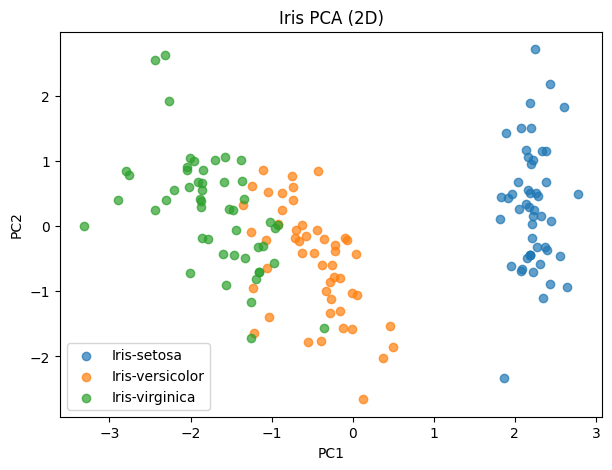

In [8]:
classes = np.unique(y_iris)
plt.figure(figsize=(7,5))
for c in classes:
    m = (y_iris == c)
    plt.scatter(Z[m,0], Z[m,1], label=c, alpha=0.7)
plt.title("Iris PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [9]:
U, s, Vt = np.linalg.svd(Xc, full_matrices=False)
k = 2
Xk = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
rmse_recon = float(np.sqrt(np.mean((Xc - Xk)**2)))

print("First 6 singular values:", np.round(s[:6], 4))
print("Rank-2 reconstruction RMSE:", rmse_recon)

First 6 singular values: [20.8955 11.7551  4.7014  1.7582]
Rank-2 reconstruction RMSE: 0.20491521755394418


# 3. Probability foundations

Probability helps us formalize uncertainty. In ML, it shows up in:

- **Generative modeling**: modeling $p(x,y)$.
- **Discriminative modeling**: modeling $p(y\mid x)$ directly.
- **Loss functions**: many are negative log-likelihoods.

## 3.1 Expectation and variance

For a random variable $X$:

$$
\mathbb{E}[X] = \sum_x x\,P(X=x)
$$

or the integral form for continuous distributions.

Variance:

$$
\mathrm{Var}(X)=\mathbb{E}[(X-\mathbb{E}[X])^2]
$$

Sample estimates approximate the population quantities; with enough data they stabilize (LLN).

## 3.2 Bayes’ rule

Bayes is a relationship between conditional probabilities:

$$
P(A\mid B)=\frac{P(B\mid A)P(A)}{P(B)}
$$

In classification, you can view $P(A)$ as a prior and $P(B\mid A)$ as a class-conditional likelihood.

## 3.3 Likelihood, log-likelihood, and log loss

For i.i.d. samples:

$$
L(\theta)=\prod_{i=1}^n p_\theta(y_i\mid x_i)
$$

Log-likelihood:

$$
\log L(\theta) = \sum_{i=1}^n \log p_\theta(y_i\mid x_i)
$$

Log loss is (up to constants) the negative average log-likelihood. It penalizes overconfident mistakes more strongly than accuracy.

## 3.4 LLN and CLT intuition (simulation)

LLN suggests sample averages converge to expectation.

CLT suggests that for many distributions, the standardized average approaches a normal distribution.

In [10]:
# Quick probability/statistics: feature summaries + Naive Bayes on iris
wine_num = wine.select_dtypes(include=[np.number])
summary = wine_num.agg(["mean","std","min","max"]).T.sort_values("std", ascending=False)
display(summary.head(10))

X = iris.drop(columns=["classification"]).values.astype(float)
y = iris["classification"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train_s, y_train)

proba = gnb.predict_proba(X_test_s)
pred = gnb.predict(X_test_s)

print("Naive Bayes accuracy:", accuracy_score(y_test, pred))
print("Naive Bayes log loss:", log_loss(y_test, proba, labels=gnb.classes_))

,mean,std,min,max
total sulfur dioxide,138.360657,42.498065,9.00,440.00
free sulfur dioxide,35.308085,17.007137,2.00,289.00
residual sugar,6.391415,5.072058,0.60,65.80
alcohol,10.514267,1.230621,8.00,14.20
quality,5.877909,0.885639,3.00,9.00
fixed acidity,6.854788,0.843868,3.80,14.20
pH,3.188267,0.151001,2.72,3.82
citric acid,0.334192,0.121020,0.00,1.66
sulphates,0.489847,0.114126,0.22,1.08
volatile acidity,0.278241,0.100795,0.08,1.10


Naive Bayes accuracy: 1.0
Naive Bayes log loss: 0.03767792192569634


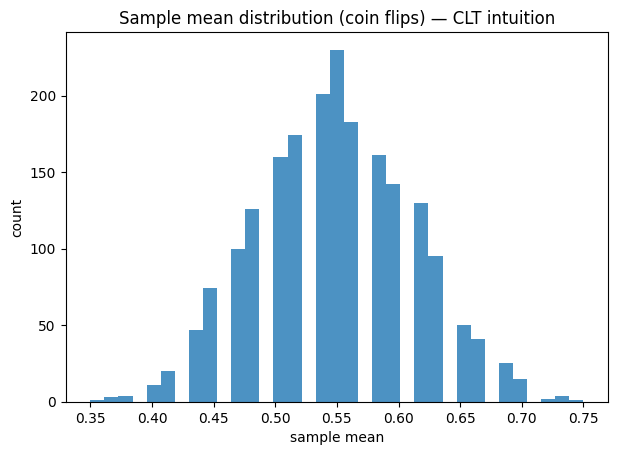

Empirical mean: 0.5481166666666666
Empirical std: 0.06333822568823137
CLT approx std: 0.06422616289332565


In [11]:
# LLN/CLT intuition with coin flips
p = 0.55
n = 60
trials = 2000
sample_means = rng.binomial(1, p, size=(trials, n)).mean(axis=1)

plt.figure(figsize=(7,4.8))
plt.hist(sample_means, bins=35, alpha=0.8)
plt.title("Sample mean distribution (coin flips) — CLT intuition")
plt.xlabel("sample mean")
plt.ylabel("count")
plt.show()

print("Empirical mean:", float(sample_means.mean()))
print("Empirical std:", float(sample_means.std(ddof=0)))
print("CLT approx std:", math.sqrt(p*(1-p)/n))

# 4. Optimization foundations

Almost every training procedure in classical ML can be written as:

$$
\min_{\theta}\; J(\theta)=\frac{1}{n}\sum_{i=1}^n \ell(f_\theta(x_i),y_i)+\lambda \Omega(\theta)
$$

- The first term is data fit (empirical risk).
- The second term controls complexity (regularization).

## 4.1 Gradients and gradient descent

Gradient descent updates:

$$
\theta \leftarrow \theta - \eta \nabla J(\theta)
$$

Here $\eta$ is the learning rate. If $\eta$ is too small, progress is slow; if too large, the method can diverge.

## 4.2 Logistic regression and cross-entropy

Binary logistic model:

$$
p(y=1\mid x)=\sigma(w^T x + b), \quad \sigma(z)=\frac{1}{1+e^{-z}}
$$

Cross-entropy (log loss):

$$
J = -\frac{1}{n}\sum_{i=1}^n\left[y_i\log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i)\right]
$$

## 4.3 Ridge regression (shrinkage)

Ridge:

$$
\min_{\beta}\; \|y-X\beta\|_2^2+\lambda\|\beta\|_2^2
$$

As $\lambda$ increases, coefficients shrink, variance decreases, and bias increases.

RMSE (GD): 11543.411504377375


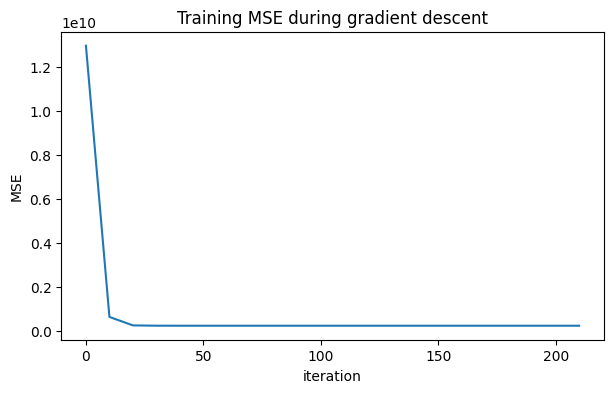

In [12]:
# Gradient descent for linear regression (MSE) on house numeric subset
Xh = house[["SqFt","Bedrooms","Bathrooms","Offers"]].values.astype(float)
yh = house["Price"].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(Xh, yh, test_size=0.25, random_state=RANDOM_SEED)

sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)

Xtr = np.c_[np.ones(len(X_train_s)), X_train_s]
Xte = np.c_[np.ones(len(X_test_s)),  X_test_s]

def mse(beta, X, y):
    r = X @ beta - y
    return float(np.mean(r**2))

def grad(beta, X, y):
    r = X @ beta - y
    return (2.0/len(y)) * (X.T @ r)

beta = np.zeros(Xtr.shape[1])
eta = 0.08
steps = 220
losses = []

for t in range(steps):
    beta -= eta * grad(beta, Xtr, y_train)
    if t % 10 == 0:
        losses.append(mse(beta, Xtr, y_train))

rmse_gd = math.sqrt(mean_squared_error(y_test, Xte @ beta))
print("RMSE (GD):", rmse_gd)

plt.figure(figsize=(7,4))
plt.plot(np.arange(len(losses))*10, losses)
plt.title("Training MSE during gradient descent")
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.show()

GD accuracy: 1.0
GD log loss: 0.021142088157384605


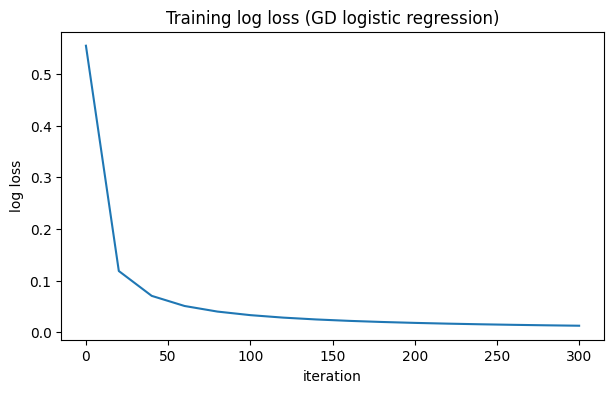

sklearn accuracy: 1.0
sklearn log loss: 0.030454990049188058


In [13]:
# Logistic regression as optimization: binary iris (setosa vs not)
X = iris.drop(columns=["classification"]).values.astype(float)
y = (iris["classification"].values == "Iris-setosa").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Xtr = np.c_[np.ones(len(X_train)), X_train]
Xte = np.c_[np.ones(len(X_test)),  X_test]

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def logloss(y, p):
    p = np.clip(p, 1e-12, 1-1e-12)
    return float(-np.mean(y*np.log(p) + (1-y)*np.log(1-p)))

w = np.zeros(Xtr.shape[1])
eta = 0.25
steps = 320
hist = []

for t in range(steps):
    p = sigmoid(Xtr @ w)
    g = (1.0/len(y_train)) * (Xtr.T @ (p - y_train))
    w -= eta * g
    if t % 20 == 0:
        hist.append(logloss(y_train, sigmoid(Xtr @ w)))

p_test = sigmoid(Xte @ w)
pred = (p_test >= 0.5).astype(int)
print("GD accuracy:", accuracy_score(y_test, pred))
print("GD log loss:", logloss(y_test, p_test))

plt.figure(figsize=(7,4))
plt.plot(np.arange(len(hist))*20, hist)
plt.title("Training log loss (GD logistic regression)")
plt.xlabel("iteration")
plt.ylabel("log loss")
plt.show()

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)
p_sk = clf.predict_proba(X_test)[:,1]
print("sklearn accuracy:", accuracy_score(y_test, (p_sk>=0.5).astype(int)))
print("sklearn log loss:", logloss(y_test, p_sk))

In [14]:
# Ridge regression shrinkage: RMSE vs lambda
Xh = house[["SqFt","Bedrooms","Bathrooms","Offers"]].values.astype(float)
yh = house["Price"].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(Xh, yh, test_size=0.25, random_state=RANDOM_SEED)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

lams = [0.0, 0.1, 1.0, 10.0, 100.0]
rows = []
for lam in lams:
    model = Ridge(alpha=lam)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    rows.append({"lambda": lam, "rmse": rmse, "coef_norm": float(np.linalg.norm(model.coef_))})

display(pd.DataFrame(rows))

,lambda,rmse,coef_norm
0,0.0,11543.411186,21422.215903
1,0.1,11548.344075,21391.381463
2,1.0,11595.570578,21119.784696
3,10.0,12240.013961,18866.457846
4,100.0,17793.334496,10212.104641


# 5. Synthesis: one unifying view

A useful unifying picture is:

- Linear algebra defines the *representation* of data ($X$) and the geometry of prediction.
- Probability defines the *meaning* of loss (log-likelihood, uncertainty, calibration).
- Optimization defines the *procedure* to find parameters (gradient descent, closed-form solvers, regularization paths).

When you later study SVMs, trees, ensembles, and probabilistic models, these same pillars reappear. The details change, but the structure is stable.

Using columns: Height(Inches) and Weight(Pounds)
Cluster centers (Height, Weight):
[[ 69.373 140.66 ]
 [ 66.665 110.458]
 [ 67.594 126.05 ]]


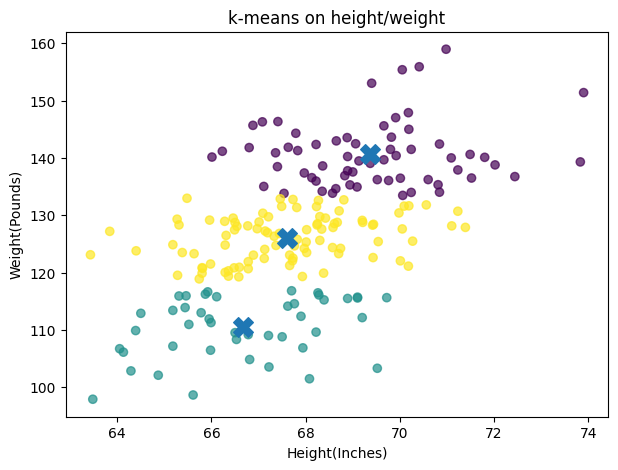

In [15]:
# k-means clustering on height/weight (geometry + optimization)

# Some versions of hw_200.csv include stray quotes/spaces in headers.
# We therefore detect the height/weight columns robustly.
cols = list(hw.columns)
height_col = next((c for c in cols if "height" in c.lower()), None)
weight_col = next((c for c in cols if "weight" in c.lower()), None)

if height_col is None or weight_col is None:
    raise ValueError(f"Could not find Height/Weight columns. Available columns: {cols}")

X_hw = hw[[height_col, weight_col]].apply(pd.to_numeric, errors="coerce").dropna().values.astype(float)

km = KMeans(n_clusters=3, random_state=RANDOM_SEED, n_init=10)
labels = km.fit_predict(X_hw)
centers = km.cluster_centers_

print("Using columns:", height_col, "and", weight_col)
print("Cluster centers (Height, Weight):")
print(np.round(centers, 3))

plt.figure(figsize=(7,5))
plt.scatter(X_hw[:,0], X_hw[:,1], c=labels, alpha=0.7)
plt.scatter(centers[:,0], centers[:,1], marker="X", s=200)
plt.title("k-means on height/weight")
plt.xlabel(height_col)
plt.ylabel(weight_col)
plt.show()

# 6. Exercises

## Conceptual
1. Explain, in your own words, why $X^T X$ appears in least squares.
2. Why can accuracy be misleading when classes are imbalanced? Why does log loss often help?
3. What does a large condition number mean for optimization and numerical stability?

## Coding (use your repo datasets)
1. **drug200**: one-hot encode `Sex`, `BP`, `Cholesterol`. Train multinomial logistic regression to predict `Drug`. Report accuracy and log loss.
2. **Wine Quality**: define a binary label `is_good = 1[quality >= 7]`. Compare Gaussian Naïve Bayes and Logistic Regression.
3. **house-prices**: compare least squares vs ridge for several $\lambda$ values and plot RMSE vs $\lambda$ on a log scale.
4. **hw_200**: run k-means for $k=2,3,4,5$ and compute inertia; plot inertia vs $k$ and interpret the elbow.

Try to write each experiment so it is repeatable with a fixed random seed.